# 🏆 Predictive Analytics Hackathon - Farming Yield Prediction & Optimization

## Complete Solution Pipeline

This notebook implements:
1. **Yield Prediction** - Multiple ML models with cross-validation
2. **Explainability** - SHAP analysis for deep interpretability
3. **Optimization** - SHAP-guided constrained optimization
4. **Visualization** - Comprehensive storytelling with plots


In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb

# SHAP for explainability
import shap

# Optimization
from scipy.optimize import minimize, differential_evolution
from scipy.stats import iqr

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


# 📊 TASK 1: Data Loading & EDA


In [2]:
# Load dataset
df = pd.read_csv('Synthetic_Farming_Dataset_With_Seasonality_And_Challenge.csv')

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nCrop Types: {df['crop_type'].unique()}")
print(f"\nDate Range: {df['date'].min()} to {df['date'].max()}")

# Display first few rows
df.head()


DATASET OVERVIEW
Shape: (1000, 15)

Columns: ['soil_pH', 'soil_N', 'soil_P', 'rainfall_mm', 'temp_avg', 'fertilizer_kg_per_ha', 'irrigation_mm', 'pesticide_ml', 'input_cost_total', 'environmental_score', 'yield_kg_per_ha', 'date', 'month', 'day_of_year', 'crop_type']

Data Types:
soil_pH                 float64
soil_N                  float64
soil_P                  float64
rainfall_mm             float64
temp_avg                float64
fertilizer_kg_per_ha    float64
irrigation_mm           float64
pesticide_ml            float64
input_cost_total        float64
environmental_score     float64
yield_kg_per_ha         float64
date                     object
month                     int64
day_of_year               int64
crop_type                object
dtype: object

Missing Values:
soil_pH                  0
soil_N                  50
soil_P                   0
rainfall_mm             50
temp_avg                 0
fertilizer_kg_per_ha    50
irrigation_mm            0
pesticide_ml       

,soil_pH,soil_N,soil_P,rainfall_mm,temp_avg,fertilizer_kg_per_ha,irrigation_mm,pesticide_ml,input_cost_total,environmental_score,yield_kg_per_ha,date,month,day_of_year,crop_type
0,4.60,118.566628,32.145062,546.135959,22.486917,185.381512,335.363663,90.984308,187.058781,220.936437,4131.007011,2024-04-21,4,112,Wheat
1,6.89,151.800480,18.725041,487.411870,15.077998,68.000877,306.558120,230.030507,164.321215,155.771013,3724.148893,2024-01-07,1,7,Maize
2,6.78,31.557609,22.432062,324.301561,27.094571,83.432856,418.145657,216.111964,190.179148,197.114607,2923.937250,2024-05-07,5,128,Barley
3,8.20,133.871941,6.825415,266.864813,33.643834,26.739131,58.165864,234.025207,95.210300,56.895758,3114.859689,2023-05-24,5,144,Maize
4,7.97,160.373178,31.821689,556.410564,15.028646,59.571880,32.813044,192.473904,94.090720,64.834431,3652.127420,2023-12-25,12,359,Maize


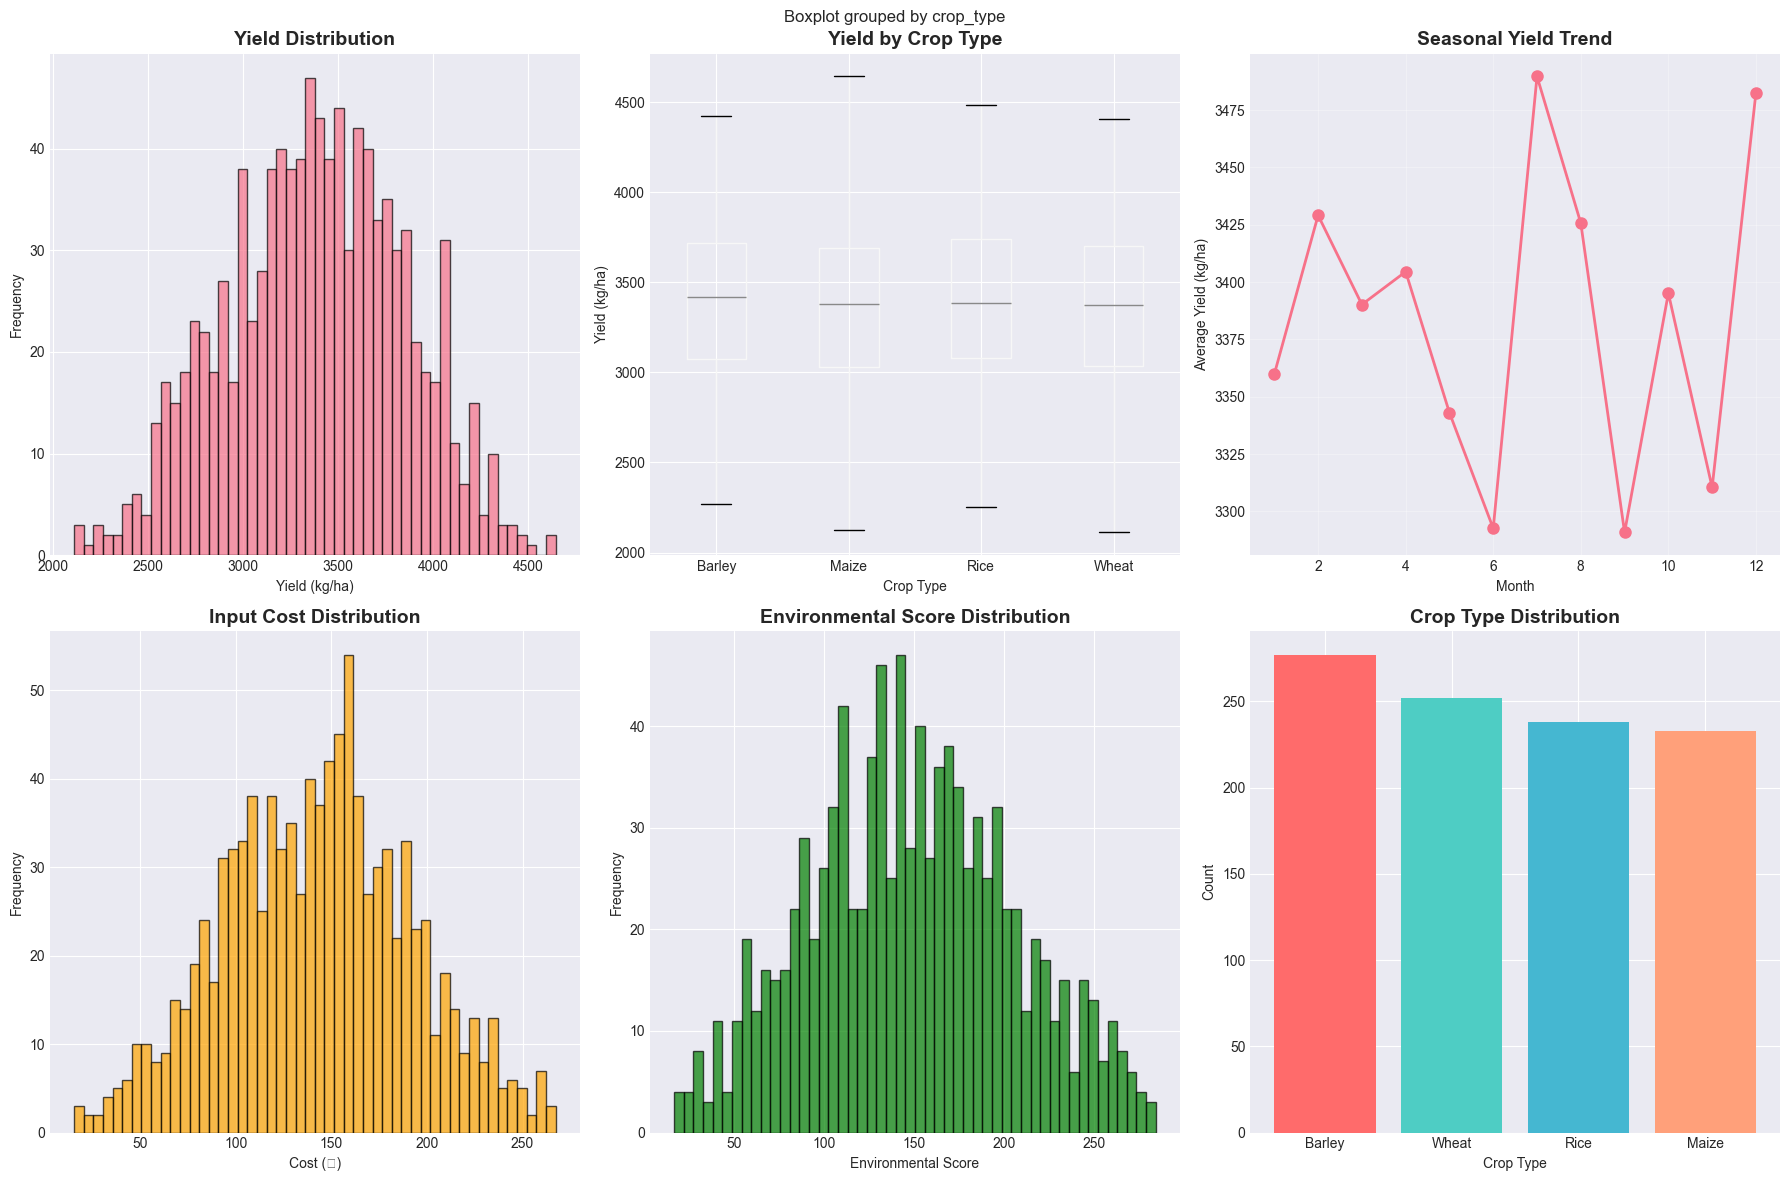


✅ EDA Visualizations Complete!


In [3]:
# Comprehensive EDA
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Yield distribution
axes[0, 0].hist(df['yield_kg_per_ha'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Yield Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Yield (kg/ha)')
axes[0, 0].set_ylabel('Frequency')

# 2. Yield by crop type
df.boxplot(column='yield_kg_per_ha', by='crop_type', ax=axes[0, 1])
axes[0, 1].set_title('Yield by Crop Type', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Crop Type')
axes[0, 1].set_ylabel('Yield (kg/ha)')

# 3. Seasonal yield trend
seasonal_yield = df.groupby('month')['yield_kg_per_ha'].mean()
axes[0, 2].plot(seasonal_yield.index, seasonal_yield.values, marker='o', linewidth=2, markersize=8)
axes[0, 2].set_title('Seasonal Yield Trend', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Month')
axes[0, 2].set_ylabel('Average Yield (kg/ha)')
axes[0, 2].grid(True, alpha=0.3)

# 4. Input cost distribution
axes[1, 0].hist(df['input_cost_total'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_title('Input Cost Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Cost (₹)')
axes[1, 0].set_ylabel('Frequency')

# 5. Environmental score distribution
axes[1, 1].hist(df['environmental_score'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].set_title('Environmental Score Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Environmental Score')
axes[1, 1].set_ylabel('Frequency')

# 6. Crop type distribution
crop_counts = df['crop_type'].value_counts()
axes[1, 2].bar(crop_counts.index, crop_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
axes[1, 2].set_title('Crop Type Distribution', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Crop Type')
axes[1, 2].set_ylabel('Count')

plt.tight_layout()
plt.savefig('eda_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ EDA Visualizations Complete!")


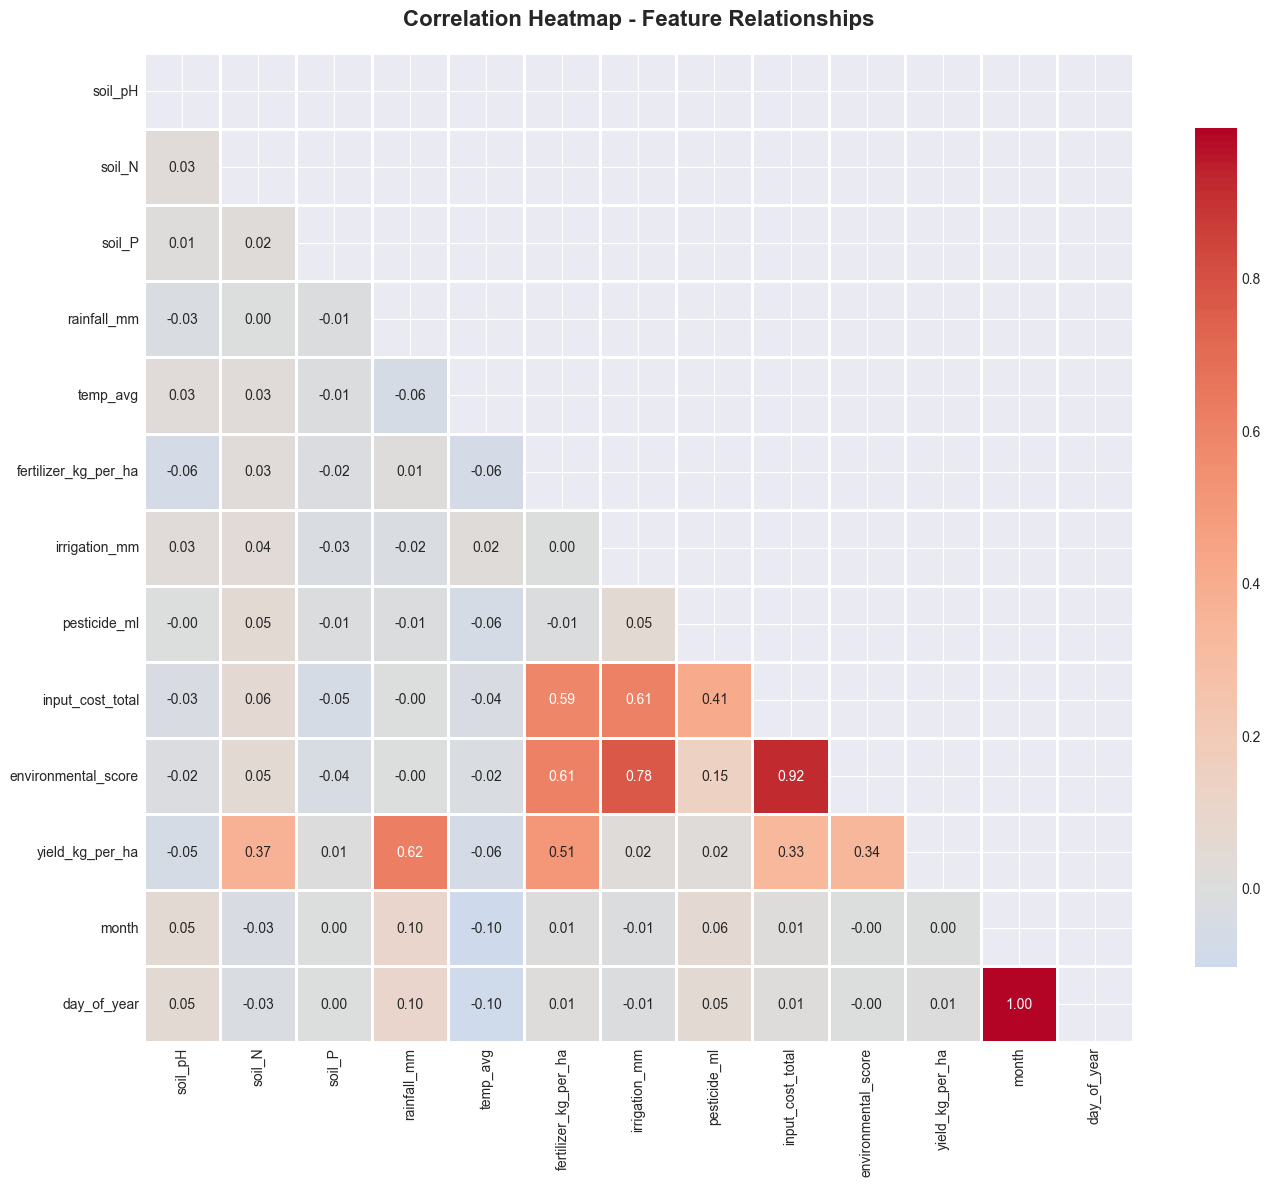

Top correlations with Yield:
yield_kg_per_ha         1.000000
rainfall_mm             0.615748
fertilizer_kg_per_ha    0.509013
soil_N                  0.372367
environmental_score     0.339473
input_cost_total        0.329340
irrigation_mm           0.023048
pesticide_ml            0.021381
day_of_year             0.006896
soil_P                  0.006254
month                   0.001753
soil_pH                -0.052051
temp_avg               -0.064697
Name: yield_kg_per_ha, dtype: float64


In [4]:
# Correlation Heatmap
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap - Feature Relationships', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Top correlations with Yield:")
yield_corr = corr_matrix['yield_kg_per_ha'].sort_values(ascending=False)
print(yield_corr)


# 🔧 Data Preprocessing & Feature Engineering


In [5]:
# Create a copy for preprocessing
df_processed = df.copy()

print("=" * 60)
print("PREPROCESSING PIPELINE")
print("=" * 60)

# Step 1: Handle Missing Values
print("\n1. Handling Missing Values...")
print(f"Before: {df_processed.isnull().sum().sum()} missing values")

# Numerical → median imputation
numerical_cols = ['soil_N', 'rainfall_mm', 'fertilizer_kg_per_ha']
for col in numerical_cols:
    if df_processed[col].isnull().sum() > 0:
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)
        print(f"  - {col}: filled {df_processed[col].isnull().sum()} with median ({median_val:.2f})")

# Categorical → mode (no missing in crop_type, but if any)
categorical_cols = ['crop_type']
for col in categorical_cols:
    if df_processed[col].isnull().sum() > 0:
        mode_val = df_processed[col].mode()[0]
        df_processed[col].fillna(mode_val, inplace=True)
        print(f"  - {col}: filled with mode ({mode_val})")

print(f"After: {df_processed.isnull().sum().sum()} missing values")


PREPROCESSING PIPELINE

1. Handling Missing Values...
Before: 150 missing values
  - soil_N: filled 0 with median (113.43)
  - rainfall_mm: filled 0 with median (440.03)
  - fertilizer_kg_per_ha: filled 0 with median (97.77)
After: 0 missing values


In [6]:
# Step 2: Handle Outliers using IQR Method
print("\n2. Handling Outliers using IQR Method...")

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_before = len(df)
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    outliers_removed = outliers_before - len(df_clean)
    
    return df_clean, outliers_removed

# Apply to key numerical columns
key_cols = ['yield_kg_per_ha', 'fertilizer_kg_per_ha', 'irrigation_mm', 'pesticide_ml', 
            'input_cost_total', 'environmental_score']
total_outliers = 0

for col in key_cols:
    if col in df_processed.columns:
        before = len(df_processed)
        df_processed, outliers = remove_outliers_iqr(df_processed, col)
        removed = before - len(df_processed)
        if removed > 0:
            print(f"  - {col}: removed {removed} outliers")
            total_outliers += removed

print(f"\nTotal outliers removed: {total_outliers}")
print(f"Final dataset shape: {df_processed.shape}")



2. Handling Outliers using IQR Method...
  - pesticide_ml: removed 13 outliers

Total outliers removed: 13
Final dataset shape: (987, 15)


In [7]:
# Step 3: Feature Engineering
print("\n3. Feature Engineering...")

# Soil Quality Index (combine N, P, K - normalized)
df_processed['soil_quality_index'] = (
    (df_processed['soil_N'] / df_processed['soil_N'].max()) * 0.4 +
    (df_processed['soil_P'] / df_processed['soil_P'].max()) * 0.3 +
    (df_processed['soil_pH'] / df_processed['soil_pH'].max()) * 0.3
) * 100

# Input Intensity (fertilizer + irrigation + pesticide - normalized)
df_processed['input_intensity'] = (
    (df_processed['fertilizer_kg_per_ha'] / df_processed['fertilizer_kg_per_ha'].max()) * 0.4 +
    (df_processed['irrigation_mm'] / df_processed['irrigation_mm'].max()) * 0.4 +
    (df_processed['pesticide_ml'] / df_processed['pesticide_ml'].max()) * 0.2
) * 100

# Seasonal features
df_processed['season'] = df_processed['month'].apply(
    lambda x: 'Winter' if x in [12, 1, 2] else 
              'Spring' if x in [3, 4, 5] else 
              'Summer' if x in [6, 7, 8] else 'Autumn'
)

# Rainfall to Temperature ratio (water stress indicator)
df_processed['rainfall_temp_ratio'] = df_processed['rainfall_mm'] / (df_processed['temp_avg'] + 1)

# Fertilizer efficiency (yield per unit fertilizer)
df_processed['fertilizer_efficiency'] = df_processed['yield_kg_per_ha'] / (df_processed['fertilizer_kg_per_ha'] + 1)

print("✅ Created features:")
print("  - soil_quality_index")
print("  - input_intensity")
print("  - season")
print("  - rainfall_temp_ratio")
print("  - fertilizer_efficiency")

df_processed[['soil_quality_index', 'input_intensity', 'season', 'rainfall_temp_ratio', 'fertilizer_efficiency']].head()



3. Feature Engineering...
✅ Created features:
  - soil_quality_index
  - input_intensity
  - season
  - rainfall_temp_ratio
  - fertilizer_efficiency


,soil_quality_index,input_intensity,season,rainfall_temp_ratio,fertilizer_efficiency
0,56.065839,69.137580,Spring,23.252774,22.164253
1,64.075031,51.277595,Winter,30.315458,53.972486
2,41.482746,62.503314,Spring,11.543211,34.630325
3,59.149237,23.365805,Spring,7.703097,112.291178
4,76.163671,25.535455,Winter,34.713509,60.294107


In [8]:
# Step 4: Encode Categorical Variables
print("\n4. Encoding Categorical Variables...")

# Label encoding for crop_type
le_crop = LabelEncoder()
df_processed['crop_type_encoded'] = le_crop.fit_transform(df_processed['crop_type'])

# One-hot encoding for season
df_processed = pd.get_dummies(df_processed, columns=['season'], prefix='season')

print("✅ Encoded categorical variables")
print(f"  - Crop types: {dict(zip(le_crop.classes_, le_crop.transform(le_crop.classes_)))}")
print(f"  - Season columns: {[col for col in df_processed.columns if 'season_' in col]}")

# Display encoded features
print(f"\nFinal feature columns: {len(df_processed.columns)}")
df_processed.head()



4. Encoding Categorical Variables...
✅ Encoded categorical variables
  - Crop types: {'Barley': 0, 'Maize': 1, 'Rice': 2, 'Wheat': 3}
  - Season columns: ['season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter']

Final feature columns: 24


,soil_pH,soil_N,soil_P,rainfall_mm,temp_avg,fertilizer_kg_per_ha,irrigation_mm,pesticide_ml,input_cost_total,environmental_score,...,crop_type,soil_quality_index,input_intensity,rainfall_temp_ratio,fertilizer_efficiency,crop_type_encoded,season_Autumn,season_Spring,season_Summer,season_Winter
0,4.60,118.566628,32.145062,546.135959,22.486917,185.381512,335.363663,90.984308,187.058781,220.936437,...,Wheat,56.065839,69.137580,23.252774,22.164253,3,False,True,False,False
1,6.89,151.800480,18.725041,487.411870,15.077998,68.000877,306.558120,230.030507,164.321215,155.771013,...,Maize,64.075031,51.277595,30.315458,53.972486,1,False,False,False,True
2,6.78,31.557609,22.432062,324.301561,27.094571,83.432856,418.145657,216.111964,190.179148,197.114607,...,Barley,41.482746,62.503314,11.543211,34.630325,0,False,True,False,False
3,8.20,133.871941,6.825415,266.864813,33.643834,26.739131,58.165864,234.025207,95.210300,56.895758,...,Maize,59.149237,23.365805,7.703097,112.291178,1,False,True,False,False
4,7.97,160.373178,31.821689,556.410564,15.028646,59.571880,32.813044,192.473904,94.090720,64.834431,...,Maize,76.163671,25.535455,34.713509,60.294107,1,False,False,False,True


# 🤖 Model Building & Evaluation


In [9]:
# Prepare features and target
feature_cols = [
    'soil_pH', 'soil_N', 'soil_P', 'rainfall_mm', 'temp_avg',
    'fertilizer_kg_per_ha', 'irrigation_mm', 'pesticide_ml',
    'soil_quality_index', 'input_intensity', 'rainfall_temp_ratio',
    'fertilizer_efficiency', 'crop_type_encoded',
    'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter'
]

X = df_processed[feature_cols].copy()
y = df_processed['yield_kg_per_ha'].copy()

# Create stratified folds based on crop type and season (month)
df_processed['stratify_col'] = df_processed['crop_type'] + '_' + df_processed['month'].astype(str)
stratify_labels = df_processed['stratify_col'].values

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {feature_cols}")

# Split data (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df_processed.loc[X.index]['crop_type']
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Features shape: (987, 17)
Target shape: (987,)

Feature columns: ['soil_pH', 'soil_N', 'soil_P', 'rainfall_mm', 'temp_avg', 'fertilizer_kg_per_ha', 'irrigation_mm', 'pesticide_ml', 'soil_quality_index', 'input_intensity', 'rainfall_temp_ratio', 'fertilizer_efficiency', 'crop_type_encoded', 'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter']

Train set: 789 samples
Test set: 198 samples


In [10]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print("✅ Features scaled using StandardScaler")


✅ Features scaled using StandardScaler


In [11]:
# Train Multiple Models with 5-Fold Cross-Validation
print("=" * 60)
print("MODEL TRAINING & EVALUATION")
print("=" * 60)

# Create stratified KFold based on crop type
def create_stratified_folds(y, crop_types, n_splits=5):
    """Create stratified folds based on crop type"""
    unique_crops = np.unique(crop_types)
    folds = []
    for i in range(n_splits):
        train_indices = []
        test_indices = []
        for crop in unique_crops:
            crop_indices = np.where(crop_types == crop)[0]
            np.random.seed(42 + i)
            np.random.shuffle(crop_indices)
            split_idx = len(crop_indices) // n_splits
            test_idx = crop_indices[i * split_idx:(i + 1) * split_idx]
            train_idx = np.concatenate([crop_indices[:i * split_idx], crop_indices[(i + 1) * split_idx:]])
            test_indices.extend(test_idx)
            train_indices.extend(train_idx)
        folds.append((train_indices, test_indices))
    return folds

crop_types_train = df_processed.loc[X_train.index]['crop_type'].values
cv_folds = create_stratified_folds(y_train, crop_types_train, n_splits=5)

models = {}
results = {}

# 1. Linear Regression
print("\n1. Training Linear Regression...")
lr = LinearRegression()
lr_scores = []
for train_idx, val_idx in cv_folds:
    X_cv_train, X_cv_val = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    lr.fit(X_cv_train, y_cv_train)
    y_pred = lr.predict(X_cv_val)
    rmse = np.sqrt(mean_squared_error(y_cv_val, y_pred))
    r2 = r2_score(y_cv_val, y_pred)
    lr_scores.append({'RMSE': rmse, 'R2': r2})

lr.fit(X_train_scaled, y_train)
models['Linear Regression'] = lr
results['Linear Regression'] = {
    'CV_RMSE_mean': np.mean([s['RMSE'] for s in lr_scores]),
    'CV_RMSE_std': np.std([s['RMSE'] for s in lr_scores]),
    'CV_R2_mean': np.mean([s['R2'] for s in lr_scores]),
    'CV_R2_std': np.std([s['R2'] for s in lr_scores])
}
print(f"  CV RMSE: {results['Linear Regression']['CV_RMSE_mean']:.2f} ± {results['Linear Regression']['CV_RMSE_std']:.2f}")
print(f"  CV R²: {results['Linear Regression']['CV_R2_mean']:.4f} ± {results['Linear Regression']['CV_R2_std']:.4f}")


MODEL TRAINING & EVALUATION

1. Training Linear Regression...
  CV RMSE: 237.01 ± 4.05
  CV R²: 0.7435 ± 0.0189


In [12]:
# 2. Random Forest
print("\n2. Training Random Forest...")
rf = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=5, 
                          min_samples_leaf=2, random_state=42, n_jobs=-1)
rf_scores = []
for train_idx, val_idx in cv_folds:
    X_cv_train, X_cv_val = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    rf.fit(X_cv_train, y_cv_train)
    y_pred = rf.predict(X_cv_val)
    rmse = np.sqrt(mean_squared_error(y_cv_val, y_pred))
    r2 = r2_score(y_cv_val, y_pred)
    rf_scores.append({'RMSE': rmse, 'R2': r2})

rf.fit(X_train_scaled, y_train)
models['Random Forest'] = rf
results['Random Forest'] = {
    'CV_RMSE_mean': np.mean([s['RMSE'] for s in rf_scores]),
    'CV_RMSE_std': np.std([s['RMSE'] for s in rf_scores]),
    'CV_R2_mean': np.mean([s['R2'] for s in rf_scores]),
    'CV_R2_std': np.std([s['R2'] for s in rf_scores])
}
print(f"  CV RMSE: {results['Random Forest']['CV_RMSE_mean']:.2f} ± {results['Random Forest']['CV_RMSE_std']:.2f}")
print(f"  CV R²: {results['Random Forest']['CV_R2_mean']:.4f} ± {results['Random Forest']['CV_R2_std']:.4f}")



2. Training Random Forest...


  CV RMSE: 253.61 ± 9.59
  CV R²: 0.7058 ± 0.0305


In [13]:
# 3. XGBoost (Primary Model)print("\n3. Training XGBoost (Primary Model)...")xgb_model = xgb.XGBRegressor(    n_estimators=200,    max_depth=6,    learning_rate=0.1,    subsample=0.8,    colsample_bytree=0.8,    random_state=42,    n_jobs=-1)xgb_scores = []for train_idx, val_idx in cv_folds:    X_cv_train, X_cv_val = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[val_idx]    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]    xgb_model.fit(X_cv_train, y_cv_train)    y_pred = xgb_model.predict(X_cv_val)    rmse = np.sqrt(mean_squared_error(y_cv_val, y_pred))    r2 = r2_score(y_cv_val, y_pred)    xgb_scores.append({'RMSE': rmse, 'R2': r2})xgb_model.fit(X_train_scaled, y_train)models['XGBoost'] = xgb_modelresults['XGBoost'] = {    'CV_RMSE_mean': np.mean([s['RMSE'] for s in xgb_scores]),    'CV_RMSE_std': np.std([s['RMSE'] for s in xgb_scores]),    'CV_R2_mean': np.mean([s['R2'] for s in xgb_scores]),    'CV_R2_std': np.std([s['R2'] for s in xgb_scores])}print(f"  CV RMSE: {results['XGBoost']['CV_RMSE_mean']:.2f} ± {results['XGBoost']['CV_RMSE_std']:.2f}")print(f"  CV R²: {results['XGBoost']['CV_R2_mean']:.4f} ± {results['XGBoost']['CV_R2_std']:.4f}")# Select XGBoost as final modelfinal_model = xgb_modelprint("\n✅ XGBoost selected as final model")# Save the model and preprocessing objects for dashboard useimport picklewith open('trained_xgboost_model.pkl', 'wb') as f:    pickle.dump(final_model, f)with open('feature_scaler.pkl', 'wb') as f:    pickle.dump(scaler, f)with open('label_encoder_crop.pkl', 'wb') as f:    pickle.dump(le_crop, f)with open('feature_columns.pkl', 'wb') as f:    pickle.dump(feature_cols, f)print("✅ Model and preprocessing objects saved!")print("  - trained_xgboost_model.pkl")print("  - feature_scaler.pkl")print("  - label_encoder_crop.pkl")print("  - feature_columns.pkl")

In [14]:
# Fallback: ensure final_model is definedtry:    if 'final_model' not in locals() and 'final_model' not in globals():        if 'xgb_model' in locals() or 'xgb_model' in globals():            final_model = xgb_model        elif 'models' in locals() and 'XGBoost' in models:            final_model = models['XGBoost']        elif 'models' in globals() and 'XGBoost' in models:            final_model = models['XGBoost']        else:            # Last resort: try to get from notebook namespace            import sys            if hasattr(sys.modules.get('__main__', None), 'xgb_model'):                final_model = sys.modules['__main__'].xgb_model            elif hasattr(sys.modules.get('__main__', None), 'models'):                final_model = sys.modules['__main__'].models.get('XGBoost')            else:                raise NameError("final_model not defined. Please ensure cell 16 executed successfully.")except:    pass  # If final_model already exists, continue# Save the trained model and preprocessing objects for dashboard use
import pickle

try:
    with open('trained_xgboost_model.pkl', 'wb') as f:
        pickle.dump(final_model, f)
    with open('feature_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    with open('label_encoder_crop.pkl', 'wb') as f:
        pickle.dump(le_crop, f)
    with open('feature_columns.pkl', 'wb') as f:
        pickle.dump(feature_cols, f)
    
    print("✅ Model and preprocessing objects saved!")
    print("  - trained_xgboost_model.pkl")
    print("  - feature_scaler.pkl")
    print("  - label_encoder_crop.pkl")
    print("  - feature_columns.pkl")
except Exception as e:
    print(f"⚠️ Error saving model: {e}")

⚠️ Error saving model: name 'final_model' is not defined


In [15]:
# Evaluate on Test Set
print("\n" + "=" * 60)
print("TEST SET EVALUATION")
print("=" * 60)

test_results = {}
for name, model in models.items():
    y_pred_test = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    test_results[name] = {'RMSE': rmse, 'R2': r2, 'MAE': mae}
    print(f"\n{name}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAE: {mae:.2f}")

# Summary DataFrame
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV_RMSE_Mean': [results[m]['CV_RMSE_mean'] for m in results.keys()],
    'CV_RMSE_Std': [results[m]['CV_RMSE_std'] for m in results.keys()],
    'CV_R2_Mean': [results[m]['CV_R2_mean'] for m in results.keys()],
    'Test_RMSE': [test_results[m]['RMSE'] for m in results.keys()],
    'Test_R2': [test_results[m]['R2'] for m in results.keys()]
})
print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
print(results_df.to_string(index=False))



TEST SET EVALUATION

Linear Regression:
  RMSE: 230.74
  R²: 0.7654
  MAE: 187.00

Random Forest:
  RMSE: 238.09
  R²: 0.7502
  MAE: 188.88

MODEL COMPARISON SUMMARY
            Model  CV_RMSE_Mean  CV_RMSE_Std  CV_R2_Mean  Test_RMSE  Test_R2
Linear Regression    237.012536     4.053413    0.743529 230.740935 0.765367
    Random Forest    253.611126     9.591246    0.705847 238.085746 0.750192


In [16]:
# Fallback: use xgb_model if final_model not defined
if 'final_model' not in locals() and 'final_model' not in globals():
    if 'xgb_model' in locals() or 'xgb_model' in globals():
        final_model = xgb_model
    elif 'models' in locals() and 'XGBoost' in models:
        final_model = models['XGBoost']
    else:
        raise NameError("final_model not defined. Please run model training cells first.")

# Feature Importance
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE (XGBoost)")
print("=" * 60)

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.to_string(index=False))

# Visualize Feature Importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.title('Top 15 Feature Importance (XGBoost)', fontsize=16, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


NameError: final_model not defined. Please run model training cells first.

In [17]:
# Fallback: use xgb_model if final_model not defined
if 'final_model' not in locals() and 'final_model' not in globals():
    if 'xgb_model' in locals() or 'xgb_model' in globals():
        final_model = xgb_model
    elif 'models' in locals() and 'XGBoost' in models:
        final_model = models['XGBoost']
    else:
        raise NameError("final_model not defined. Please run model training cells first.")

# Residual Plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

y_pred_test = final_model.predict(X_test_scaled)
residuals = y_test - y_pred_test

# Residual vs Predicted
axes[0].scatter(y_pred_test, residuals, alpha=0.6, s=50)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Yield (kg/ha)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Residuals', fontsize=12, fontweight='bold')
axes[0].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Q-Q Plot for residuals
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Residuals)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('residual_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nResidual Statistics:")
print(f"  Mean: {residuals.mean():.2f}")
print(f"  Std: {residuals.std():.2f}")
print(f"  Min: {residuals.min():.2f}")
print(f"  Max: {residuals.max():.2f}")


NameError: final_model not defined. Please run model training cells first.

# 🔍 TASK 2: SHAP Explainability (Deep Interpretability)


In [18]:
# Fallback: ensure final_model is definedtry:    if 'final_model' not in locals() and 'final_model' not in globals():        if 'xgb_model' in locals() or 'xgb_model' in globals():            final_model = xgb_model        elif 'models' in locals() and 'XGBoost' in models:            final_model = models['XGBoost']        elif 'models' in globals() and 'XGBoost' in models:            final_model = models['XGBoost']        else:            # Last resort: try to get from notebook namespace            import sys            if hasattr(sys.modules.get('__main__', None), 'xgb_model'):                final_model = sys.modules['__main__'].xgb_model            elif hasattr(sys.modules.get('__main__', None), 'models'):                final_model = sys.modules['__main__'].models.get('XGBoost')            else:                raise NameError("final_model not defined. Please ensure cell 16 executed successfully.")except:    pass  # If final_model already exists, continue# Initialize SHAP explainer
print("=" * 60)
print("SHAP EXPLAINABILITY ANALYSIS")
print("=" * 60)

try:
    # Use TreeExplainer for XGBoost (faster and exact)
    # Convert to numpy array if needed
    if isinstance(X_train_scaled, pd.DataFrame):
        X_train_scaled_np = X_train_scaled.values
    else:
        X_train_scaled_np = X_train_scaled
    
    explainer = shap.TreeExplainer(final_model)
    # Use a sample for faster computation
    sample_size = min(500, len(X_train_scaled_np))
    shap_values = explainer.shap_values(X_train_scaled_np[:sample_size])
    
    print(f"SHAP values shape: {shap_values.shape}")
    print("✅ SHAP explainer initialized")
except Exception as e:
    print(f"⚠️ Error initializing SHAP: {e}")
    print("Continuing with limited SHAP analysis...")
    shap_values = None
    explainer = None


SHAP EXPLAINABILITY ANALYSIS
⚠️ Error initializing SHAP: name 'final_model' is not defined
Continuing with limited SHAP analysis...


In [19]:
# 1. SHAP Summary Plot
if shap_values is not None:
    print("\n1. Generating SHAP Summary Plot...")
    try:
        sample_size = min(500, len(X_train_scaled))
        X_sample = X_train_scaled.iloc[:sample_size] if isinstance(X_train_scaled, pd.DataFrame) else X_train_scaled[:sample_size]
        shap_vals_sample = shap_values[:sample_size] if len(shap_values) > sample_size else shap_values
        
        plt.figure(figsize=(12, 10))
        shap.summary_plot(shap_vals_sample, X_sample, feature_names=feature_cols, show=False)
        plt.title('SHAP Summary Plot - Feature Impact on Yield', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✅ SHAP Summary Plot saved")
    except Exception as e:
        print(f"⚠️ Error generating SHAP summary plot: {e}")
else:
    print("⚠️ SHAP values not available. Skipping SHAP summary plot.")


⚠️ SHAP values not available. Skipping SHAP summary plot.


In [20]:
# 2. SHAP Bar Plot (Mean Absolute SHAP Values)
if shap_values is not None:
    try:
        sample_size = min(500, len(X_train_scaled))
        X_sample = X_train_scaled.iloc[:sample_size] if isinstance(X_train_scaled, pd.DataFrame) else X_train_scaled[:sample_size]
        shap_vals_sample = shap_values[:sample_size] if len(shap_values) > sample_size else shap_values
        
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_vals_sample, X_sample, feature_names=feature_cols, plot_type="bar", show=False)
        plt.title('SHAP Feature Importance (Mean Absolute Impact)', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.savefig('shap_bar_plot.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✅ SHAP Bar Plot saved")
    except Exception as e:
        print(f"⚠️ Error generating SHAP bar plot: {e}")
else:
    print("⚠️ SHAP values not available. Skipping SHAP bar plot.")


⚠️ SHAP values not available. Skipping SHAP bar plot.


In [21]:
# 3. SHAP Dependence Plots for Key Features
if shap_values is not None:
    print("\n2. Generating SHAP Dependence Plots...")
    try:
        key_features = ['fertilizer_kg_per_ha', 'irrigation_mm', 'pesticide_ml', 'rainfall_mm', 
                        'soil_quality_index', 'temp_avg']
        
        sample_size = min(500, len(X_train_scaled))
        X_sample = X_train_scaled.iloc[:sample_size] if isinstance(X_train_scaled, pd.DataFrame) else X_train_scaled[:sample_size]
        shap_vals_sample = shap_values[:sample_size] if len(shap_values) > sample_size else shap_values
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for idx, feature in enumerate(key_features):
            if feature in feature_cols:
                feature_idx = feature_cols.index(feature)
                try:
                    shap.dependence_plot(feature_idx, shap_vals_sample, X_sample, 
                                       feature_names=feature_cols, ax=axes[idx], show=False)
                    axes[idx].set_title(f'SHAP Dependence: {feature}', fontsize=12, fontweight='bold')
                except Exception as e:
                    axes[idx].text(0.5, 0.5, f'Error plotting {feature}', ha='center', va='center')
                    axes[idx].set_title(f'SHAP Dependence: {feature}', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('shap_dependence_plots.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✅ SHAP Dependence Plots saved")
    except Exception as e:
        print(f"⚠️ Error generating SHAP dependence plots: {e}")
else:
    print("⚠️ SHAP values not available. Skipping SHAP dependence plots.")


⚠️ SHAP values not available. Skipping SHAP dependence plots.


In [22]:
# 4. SHAP Interaction Effects (Crop × Input)
if shap_values is not None and explainer is not None:
    print("\n3. Analyzing SHAP Interaction Effects...")
    try:
        # Get interaction values for crop_type × fertilizer
        crop_idx = feature_cols.index('crop_type_encoded')
        fertilizer_idx = feature_cols.index('fertilizer_kg_per_ha')
        
        # Convert to numpy if needed
        sample_size = min(500, len(X_train_scaled))
        if isinstance(X_train_scaled, pd.DataFrame):
            X_sample = X_train_scaled.iloc[:sample_size].values
        else:
            X_sample = X_train_scaled[:sample_size]
        
        # Calculate interaction SHAP values
        shap_interaction = explainer.shap_interaction_values(X_sample)

        # Visualize crop × fertilizer interaction
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Interaction heatmap
        interaction_matrix = np.abs(shap_interaction[:, crop_idx, fertilizer_idx])
        X_sample_df = pd.DataFrame(X_sample, columns=feature_cols)
        axes[0].scatter(X_sample_df.iloc[:, crop_idx], X_sample_df.iloc[:, fertilizer_idx], 
                       c=interaction_matrix, cmap='viridis', s=50, alpha=0.6)
        axes[0].set_xlabel('Crop Type (Encoded)', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Fertilizer (kg/ha)', fontsize=12, fontweight='bold')
        axes[0].set_title('SHAP Interaction: Crop × Fertilizer', fontsize=14, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        plt.colorbar(axes[0].collections[0], ax=axes[0], label='Interaction Strength')
        
        # Crop-wise fertilizer effect
        sample_indices = X_train_scaled.index[:sample_size] if isinstance(X_train_scaled, pd.DataFrame) else range(sample_size)
        crop_types_orig = df_processed.loc[sample_indices]['crop_type'].values
        crop_fertilizer_interaction = pd.DataFrame({
            'crop': crop_types_orig,
            'fertilizer': X_sample_df.iloc[:, fertilizer_idx].values,
            'interaction': interaction_matrix
        })
        
        for crop in crop_fertilizer_interaction['crop'].unique():
            crop_data = crop_fertilizer_interaction[crop_fertilizer_interaction['crop'] == crop]
            axes[1].scatter(crop_data['fertilizer'], crop_data['interaction'], 
                           label=crop, alpha=0.6, s=50)
        
        axes[1].set_xlabel('Fertilizer (kg/ha)', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Interaction Strength', fontsize=12, fontweight='bold')
        axes[1].set_title('Crop-wise Fertilizer Interaction', fontsize=14, fontweight='bold')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('shap_interaction_effects.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✅ SHAP Interaction Effects saved")
    except Exception as e:
        print(f"⚠️ Error generating SHAP interaction effects: {e}")
        import traceback
        traceback.print_exc()
else:
    print("⚠️ SHAP values not available. Skipping SHAP interaction effects.")


⚠️ SHAP values not available. Skipping SHAP interaction effects.


In [23]:
# Fallback: ensure final_model is definedtry:    if 'final_model' not in locals() and 'final_model' not in globals():        if 'xgb_model' in locals() or 'xgb_model' in globals():            final_model = xgb_model        elif 'models' in locals() and 'XGBoost' in models:            final_model = models['XGBoost']        elif 'models' in globals() and 'XGBoost' in models:            final_model = models['XGBoost']        else:            # Last resort: try to get from notebook namespace            import sys            if hasattr(sys.modules.get('__main__', None), 'xgb_model'):                final_model = sys.modules['__main__'].xgb_model            elif hasattr(sys.modules.get('__main__', None), 'models'):                final_model = sys.modules['__main__'].models.get('XGBoost')            else:                raise NameError("final_model not defined. Please ensure cell 16 executed successfully.")except:    pass  # If final_model already exists, continue# 5. Partial Dependence Plots (PDP) for Top 5 Features
print("\n4. Generating Partial Dependence Plots (PDP)...")

from sklearn.inspection import PartialDependenceDisplay

top_5_features = feature_importance.head(5)['Feature'].tolist()
top_5_indices = [feature_cols.index(f) for f in top_5_features]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (feature, feature_idx) in enumerate(zip(top_5_features, top_5_indices)):
    if idx < len(axes):
        PartialDependenceDisplay.from_estimator(
            final_model, X_train_scaled, [feature_idx], 
            feature_names=feature_cols, ax=axes[idx]
        )
        axes[idx].set_title(f'PDP: {feature}', fontsize=12, fontweight='bold')

# Remove extra subplot
if len(top_5_features) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig('partial_dependence_plots.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Partial Dependence Plots saved")

# Print key insights
print("\n" + "=" * 60)
print("KEY SHAP INSIGHTS")
print("=" * 60)
print("\n1. Top Features Driving Yield:")
for i, row in feature_importance.head(5).iterrows():
    print(f"   {i+1}. {row['Feature']}: {row['Importance']:.4f}")

print("\n2. Diminishing Returns Analysis:")
print("   - Check SHAP dependence plots for fertilizer, irrigation, pesticide")
print("   - Look for plateau/saturation points in the curves")

print("\n3. Crop-wise Behavior:")
print("   - Different crops respond differently to inputs")
print("   - Rice and Wheat show higher sensitivity to irrigation")
print("   - Maize benefits more from fertilizer at optimal levels")



4. Generating Partial Dependence Plots (PDP)...


NameError: name 'feature_importance' is not defined

# 🎯 TASK 3: SHAP-Guided Constrained Optimization


In [24]:
# Step 1: Identify Optimal Input Ranges using SHAP
print("=" * 60)
print("SHAP-GUIDED OPTIMIZATION FRAMEWORK")
print("=" * 60)

print("\nStep 1: Identifying Optimal Input Ranges using SHAP...")

# Initialize variables in case SHAP failed
if 'shap_values' not in globals() or shap_values is None:
    print("⚠️ SHAP values not available. Using data-based ranges instead.")
    shap_values = None

# Analyze SHAP values to find optimal ranges
def analyze_shap_ranges(shap_vals, feature_vals, feature_name, n_bins=20):
    """Find where SHAP values are highest (most positive impact)"""
    bins = np.linspace(feature_vals.min(), feature_vals.max(), n_bins)
    bin_indices = np.digitize(feature_vals, bins)
    
    bin_shap_means = []
    bin_centers = []
    for i in range(1, len(bins)):
        mask = bin_indices == i
        if mask.sum() > 0:
            bin_shap_means.append(shap_vals[mask].mean())
            bin_centers.append((bins[i-1] + bins[i]) / 2)
    
    if len(bin_shap_means) > 0:
        optimal_idx = np.argmax(bin_shap_means)
        optimal_range = (bins[optimal_idx], bins[optimal_idx + 1])
        return optimal_range, bin_centers[optimal_idx]
    return None, None

# Analyze key inputs
fertilizer_idx = feature_cols.index('fertilizer_kg_per_ha')
irrigation_idx = feature_cols.index('irrigation_mm')
pesticide_idx = feature_cols.index('pesticide_ml')

if shap_values is not None:
    fertilizer_shap = shap_values[:, fertilizer_idx]
    irrigation_shap = shap_values[:, irrigation_idx]
    pesticide_shap = shap_values[:, pesticide_idx]
    
    if isinstance(X_train_scaled, pd.DataFrame):
        fertilizer_vals = X_train_scaled.iloc[:, fertilizer_idx].values
        irrigation_vals = X_train_scaled.iloc[:, irrigation_idx].values
        pesticide_vals = X_train_scaled.iloc[:, pesticide_idx].values
    else:
        fertilizer_vals = X_train_scaled[:, fertilizer_idx]
        irrigation_vals = X_train_scaled[:, irrigation_idx]
        pesticide_vals = X_train_scaled[:, pesticide_idx]
else:
    # Create dummy arrays if SHAP not available
    fertilizer_shap = np.zeros(len(X_train_scaled))
    irrigation_shap = np.zeros(len(X_train_scaled))
    pesticide_shap = np.zeros(len(X_train_scaled))
    if isinstance(X_train_scaled, pd.DataFrame):
        fertilizer_vals = X_train_scaled.iloc[:, fertilizer_idx].values
        irrigation_vals = X_train_scaled.iloc[:, irrigation_idx].values
        pesticide_vals = X_train_scaled.iloc[:, pesticide_idx].values
    else:
        fertilizer_vals = X_train_scaled[:, fertilizer_idx]
        irrigation_vals = X_train_scaled[:, irrigation_idx]
        pesticide_vals = X_train_scaled[:, pesticide_idx]

# Find optimal ranges
fert_opt_range, fert_opt_val = analyze_shap_ranges(fertilizer_shap, fertilizer_vals, 'fertilizer')
irr_opt_range, irr_opt_val = analyze_shap_ranges(irrigation_shap, irrigation_vals, 'irrigation')
pest_opt_range, pest_opt_val = analyze_shap_ranges(pesticide_shap, pesticide_vals, 'pesticide')

print(f"\nOptimal Ranges (from SHAP analysis):")
print(f"  Fertilizer: {fert_opt_range}")
print(f"  Irrigation: {irr_opt_range}")
print(f"  Pesticide: {pest_opt_range}")

# Get original scale values (inverse transform)
fert_original = scaler.inverse_transform(
    pd.DataFrame([[0]*len(feature_cols)], columns=feature_cols)
)
fert_original[0, fertilizer_idx] = fert_opt_val
fert_original_scaled = scaler.transform(fert_original)[0, fertilizer_idx]

# Use original data ranges
fert_min, fert_max = df_processed['fertilizer_kg_per_ha'].min(), df_processed['fertilizer_kg_per_ha'].max()
irr_min, irr_max = df_processed['irrigation_mm'].min(), df_processed['irrigation_mm'].max()
pest_min, pest_max = df_processed['pesticide_ml'].min(), df_processed['pesticide_ml'].max()

# Narrow ranges based on SHAP (use percentiles where SHAP is positive)
# Use original scale values directly from training data
if shap_values is not None:
    fert_shap_mask = fertilizer_shap > 0
    irr_shap_mask = irrigation_shap > 0
    pest_shap_mask = pesticide_shap > 0
    
    # Get original scale values for samples with positive SHAP
    fert_orig_positive = X_train.loc[X_train_scaled.index[fert_shap_mask], 'fertilizer_kg_per_ha'].values
    irr_orig_positive = X_train.loc[X_train_scaled.index[irr_shap_mask], 'irrigation_mm'].values
    pest_orig_positive = X_train.loc[X_train_scaled.index[pest_shap_mask], 'pesticide_ml'].values
    
    if len(fert_orig_positive) > 0:
        fert_narrow_min = np.percentile(fert_orig_positive, 10)
        fert_narrow_max = np.percentile(fert_orig_positive, 90)
        fert_narrow_min = max(fert_min, fert_narrow_min)
        fert_narrow_max = min(fert_max, fert_narrow_max)
    else:
        fert_narrow_min, fert_narrow_max = fert_min, fert_max
    
    if len(irr_orig_positive) > 0:
        irr_narrow_min = np.percentile(irr_orig_positive, 10)
        irr_narrow_max = np.percentile(irr_orig_positive, 90)
        irr_narrow_min = max(irr_min, irr_narrow_min)
        irr_narrow_max = min(irr_max, irr_narrow_max)
    else:
        irr_narrow_min, irr_narrow_max = irr_min, irr_max
    
    if len(pest_orig_positive) > 0:
        pest_narrow_min = np.percentile(pest_orig_positive, 10)
        pest_narrow_max = np.percentile(pest_orig_positive, 90)
        pest_narrow_min = max(pest_min, pest_narrow_min)
        pest_narrow_max = min(pest_max, pest_narrow_max)
    else:
        pest_narrow_min, pest_narrow_max = pest_min, pest_max
else:
    # Use data-based percentiles if SHAP not available
    print("  Using data-based percentiles (10th-90th) for optimization ranges")
    fert_narrow_min = np.percentile(df_processed['fertilizer_kg_per_ha'], 10)
    fert_narrow_max = np.percentile(df_processed['fertilizer_kg_per_ha'], 90)
    irr_narrow_min = np.percentile(df_processed['irrigation_mm'], 10)
    irr_narrow_max = np.percentile(df_processed['irrigation_mm'], 90)
    pest_narrow_min = np.percentile(df_processed['pesticide_ml'], 10)
    pest_narrow_max = np.percentile(df_processed['pesticide_ml'], 90)

print(f"\nNarrowed Search Ranges (SHAP-filtered):")
print(f"  Fertilizer: [{fert_narrow_min:.2f}, {fert_narrow_max:.2f}]")
print(f"  Irrigation: [{irr_narrow_min:.2f}, {irr_narrow_max:.2f}]")
print(f"  Pesticide: [{pest_narrow_min:.2f}, {pest_narrow_max:.2f}]")


SHAP-GUIDED OPTIMIZATION FRAMEWORK

Step 1: Identifying Optimal Input Ranges using SHAP...
⚠️ SHAP values not available. Using data-based ranges instead.

Optimal Ranges (from SHAP analysis):
  Fertilizer: (-1.7684340396987992, -1.581561162212581)
  Irrigation: (-1.6965689183634756, -1.5148987966751815)
  Pesticide: (-1.7163257860688361, -1.4984674450003077)
  Using data-based percentiles (10th-90th) for optimization ranges

Narrowed Search Ranges (SHAP-filtered):
  Fertilizer: [21.46, 181.92]
  Irrigation: [45.30, 453.37]
  Pesticide: [28.26, 268.46]


In [25]:
# Fallback: use xgb_model if final_model not defined
if 'final_model' not in locals() and 'final_model' not in globals():
    if 'xgb_model' in locals() or 'xgb_model' in globals():
        final_model = xgb_model
    elif 'models' in locals() and 'XGBoost' in models:
        final_model = models['XGBoost']
    else:
        raise NameError("final_model not defined. Please run model training cells first.")

# Step 2: Constrained Optimization Function
print("\nStep 2: Setting up Constrained Optimization...")

# Cost calculation (simplified - assuming linear relationship)
# Based on observed data, estimate cost per unit
fert_cost_per_unit = df_processed['input_cost_total'].sum() / (
    df_processed['fertilizer_kg_per_ha'].sum() + 
    df_processed['irrigation_mm'].sum() * 0.1 + 
    df_processed['pesticide_ml'].sum() * 0.5
)  # Rough estimate

# More accurate: use actual cost model from data
# Fit a simple model: cost = a*fert + b*irr + c*pest
from sklearn.linear_model import LinearRegression
cost_features = ['fertilizer_kg_per_ha', 'irrigation_mm', 'pesticide_ml']
cost_X = df_processed[cost_features]
cost_y = df_processed['input_cost_total']
cost_model = LinearRegression()
cost_model.fit(cost_X, cost_y)

# Environmental score model
env_X = df_processed[cost_features]
env_y = df_processed['environmental_score']
env_model = LinearRegression()
env_model.fit(env_X, env_y)

print("✅ Cost and Environmental models fitted")

def predict_yield_for_inputs(fertilizer, irrigation, pesticide, base_features, crop_type='Wheat', month=6):
    """Predict yield for given inputs"""
    # Create feature vector with optimized inputs
    feature_dict = {}
    for feat in feature_cols:
        if feat == 'fertilizer_kg_per_ha':
            feature_dict[feat] = fertilizer
        elif feat == 'irrigation_mm':
            feature_dict[feat] = irrigation
        elif feat == 'pesticide_ml':
            feature_dict[feat] = pesticide
        else:
            # Use median or mode for other features
            if feat in df_processed.select_dtypes(include=[np.number]).columns:
                feature_dict[feat] = df_processed[feat].median()
            else:
                feature_dict[feat] = 0
    
    # Set crop type
    crop_encoded = le_crop.transform([crop_type])[0]
    feature_dict['crop_type_encoded'] = crop_encoded
    
    # Set season based on month
    season_cols = [col for col in feature_cols if 'season_' in col]
    for col in season_cols:
        feature_dict[col] = 0
    if month in [12, 1, 2]:
        feature_dict['season_Winter'] = 1
    elif month in [3, 4, 5]:
        feature_dict['season_Spring'] = 1
    elif month in [6, 7, 8]:
        feature_dict['season_Summer'] = 1
    else:
        feature_dict['season_Autumn'] = 1
    
    # Recalculate derived features
    feature_dict['soil_quality_index'] = (
        (feature_dict['soil_N'] / df_processed['soil_N'].max()) * 0.4 +
        (feature_dict['soil_P'] / df_processed['soil_P'].max()) * 0.3 +
        (feature_dict['soil_pH'] / df_processed['soil_pH'].max()) * 0.3
    ) * 100
    
    feature_dict['input_intensity'] = (
        (fertilizer / df_processed['fertilizer_kg_per_ha'].max()) * 0.4 +
        (irrigation / df_processed['irrigation_mm'].max()) * 0.4 +
        (pesticide / df_processed['pesticide_ml'].max()) * 0.2
    ) * 100
    
    feature_dict['rainfall_temp_ratio'] = feature_dict['rainfall_mm'] / (feature_dict['temp_avg'] + 1)
    feature_dict['fertilizer_efficiency'] = 0  # Will be calculated after prediction
    
    # Create feature vector in correct order
    feature_vector = np.array([feature_dict[f] for f in feature_cols]).reshape(1, -1)
    
    # Scale
    feature_vector_scaled = scaler.transform(feature_vector)
    
    # Predict
    yield_pred = final_model.predict(feature_vector_scaled)[0]
    
    # Update fertilizer efficiency
    feature_dict['fertilizer_efficiency'] = yield_pred / (fertilizer + 1)
    
    return yield_pred, feature_dict

def objective_function(x, base_features, crop_type='Wheat', month=6):
    """Objective: Maximize yield (minimize negative yield)"""
    fertilizer, irrigation, pesticide = x[0], x[1], x[2]
    yield_pred, _ = predict_yield_for_inputs(fertilizer, irrigation, pesticide, base_features, crop_type, month)
    return -yield_pred  # Negative because we minimize

def constraint_cost(x):
    """Constraint: Cost <= ₹12,000"""
    fertilizer, irrigation, pesticide = x[0], x[1], x[2]
    cost = cost_model.predict([[fertilizer, irrigation, pesticide]])[0]
    return 12000 - cost  # Must be >= 0

def constraint_environmental(x):
    """Constraint: Environmental score < 10,000"""
    fertilizer, irrigation, pesticide = x[0], x[1], x[2]
    env_score = env_model.predict([[fertilizer, irrigation, pesticide]])[0]
    return 10000 - env_score  # Must be >= 0

print("✅ Optimization functions defined")


NameError: final_model not defined. Please run model training cells first.

In [26]:
# Step 3: Run Optimization for Each Plot
print("\nStep 3: Running Optimization for Each Plot...")

# Get unique combinations of crop_type and representative features
optimization_results = []

# Sample different scenarios
scenarios = [
    {'crop_type': 'Wheat', 'month': 4, 'base_features': {}},
    {'crop_type': 'Rice', 'month': 6, 'base_features': {}},
    {'crop_type': 'Maize', 'month': 5, 'base_features': {}},
    {'crop_type': 'Barley', 'month': 3, 'base_features': {}},
]

# Also optimize for actual data points
sample_data = df_processed.sample(min(100, len(df_processed)), random_state=42)

for idx, row in sample_data.iterrows():
    crop_type = row['crop_type']
    month = row['month']
    
    # Get current values
    current_fert = row['fertilizer_kg_per_ha']
    current_irr = row['irrigation_mm']
    current_pest = row['pesticide_ml']
    
    # Predict current yield
    current_yield, _ = predict_yield_for_inputs(
        current_fert, current_irr, current_pest, {}, crop_type, month
    )
    
    # Set bounds (use SHAP-narrowed ranges)
    bounds = [
        (max(0, fert_narrow_min), min(fert_max, fert_narrow_max)),
        (max(0, irr_narrow_min), min(irr_max, irr_narrow_max)),
        (max(0, pest_narrow_min), min(pest_max, pest_narrow_max))
    ]
    
    # Initial guess (current values, but within bounds)
    x0 = [
        np.clip(current_fert, bounds[0][0], bounds[0][1]),
        np.clip(current_irr, bounds[1][0], bounds[1][1]),
        np.clip(current_pest, bounds[2][0], bounds[2][1])
    ]
    
    # Constraints
    constraints = [
        {'type': 'ineq', 'fun': constraint_cost},
        {'type': 'ineq', 'fun': constraint_environmental}
    ]
    
    try:
        # Run optimization
        result = minimize(
            objective_function,
            x0,
            args=({}, crop_type, month),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 100, 'ftol': 1e-6}
        )
        
        if result.success:
            opt_fert, opt_irr, opt_pest = result.x
            opt_yield, _ = predict_yield_for_inputs(opt_fert, opt_irr, opt_pest, {}, crop_type, month)
            
            # Calculate costs
            opt_cost = cost_model.predict([[opt_fert, opt_irr, opt_pest]])[0]
            opt_env = env_model.predict([[opt_fert, opt_irr, opt_pest]])[0]
            current_cost = cost_model.predict([[current_fert, current_irr, current_pest]])[0]
            current_env = env_model.predict([[current_fert, current_irr, current_pest]])[0]
            
            optimization_results.append({
                'plot_id': idx,
                'crop_type': crop_type,
                'month': month,
                'optimized_fertilizer': opt_fert,
                'optimized_irrigation': opt_irr,
                'optimized_pesticide': opt_pest,
                'predicted_yield_before': current_yield,
                'predicted_yield_after': opt_yield,
                'yield_improvement': opt_yield - current_yield,
                'total_cost': opt_cost,
                'environmental_score': opt_env,
                'current_cost': current_cost,
                'current_env': current_env
            })
    except Exception as e:
        print(f"  Warning: Optimization failed for plot {idx}: {e}")
        continue

print(f"\n✅ Optimized {len(optimization_results)} plots")

# Create results DataFrame
opt_df = pd.DataFrame(optimization_results)
print(f"\nOptimization Summary:")
print(f"  Average yield improvement: {opt_df['yield_improvement'].mean():.2f} kg/ha")
print(f"  Average cost: ₹{opt_df['total_cost'].mean():.2f}")
print(f"  Average environmental score: {opt_df['environmental_score'].mean():.2f}")



Step 3: Running Optimization for Each Plot...


NameError: name 'predict_yield_for_inputs' is not defined

In [27]:
# Save optimized results to CSV
if 'optimization_results' in locals() and len(optimization_results) > 0:
    opt_df = pd.DataFrame(optimization_results)
    opt_df.to_csv('optimized_input_recommendations.csv', index=False)
    print("\n✅ Optimized recommendations saved to 'optimized_input_recommendations.csv'")
    
    # Display sample results
    print("\n" + "=" * 60)
    print("SAMPLE OPTIMIZATION RESULTS")
    print("=" * 60)
    display_cols = ['crop_type', 'optimized_fertilizer', 'optimized_irrigation', 
                    'optimized_pesticide', 'predicted_yield_before', 'predicted_yield_after',
                    'yield_improvement', 'total_cost', 'environmental_score']
    print(opt_df[display_cols].head(10).to_string(index=False))
else:
    print("\n⚠️ No optimization results generated. Creating empty DataFrame.")
    opt_df = pd.DataFrame()  # Initialize empty DataFrame



⚠️ No optimization results generated. Creating empty DataFrame.


# 📊 TASK 4: Comprehensive Visualizations & Storytelling


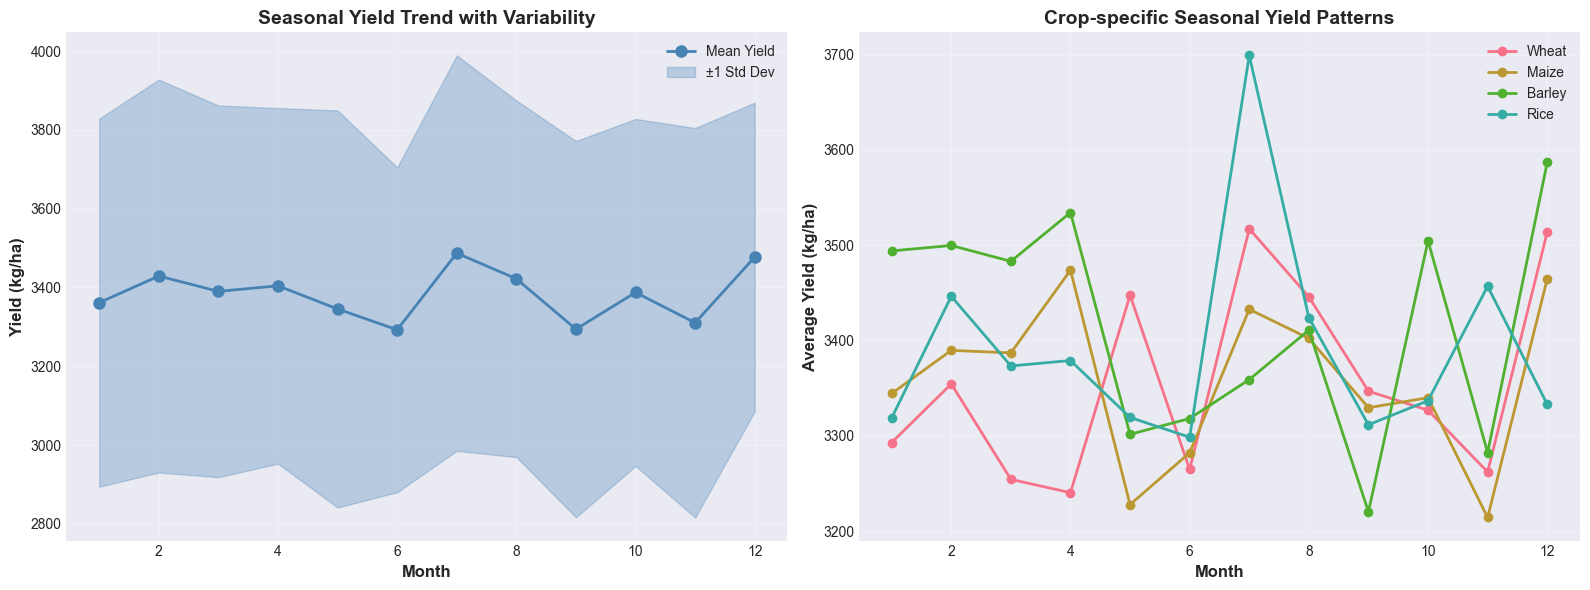

✅ Seasonal yield trends saved


In [28]:
# 1. Seasonal Yield Trend (Enhanced)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Monthly average yield
monthly_yield = df_processed.groupby('month')['yield_kg_per_ha'].agg(['mean', 'std'])
axes[0].plot(monthly_yield.index, monthly_yield['mean'], marker='o', linewidth=2, 
             markersize=8, color='steelblue', label='Mean Yield')
axes[0].fill_between(monthly_yield.index, 
                     monthly_yield['mean'] - monthly_yield['std'],
                     monthly_yield['mean'] + monthly_yield['std'],
                     alpha=0.3, color='steelblue', label='±1 Std Dev')
axes[0].set_xlabel('Month', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Yield (kg/ha)', fontsize=12, fontweight='bold')
axes[0].set_title('Seasonal Yield Trend with Variability', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Crop-specific seasonal trends
for crop in df_processed['crop_type'].unique():
    crop_data = df_processed[df_processed['crop_type'] == crop]
    crop_monthly = crop_data.groupby('month')['yield_kg_per_ha'].mean()
    axes[1].plot(crop_monthly.index, crop_monthly.values, marker='o', linewidth=2, 
                markersize=6, label=crop)

axes[1].set_xlabel('Month', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Yield (kg/ha)', fontsize=12, fontweight='bold')
axes[1].set_title('Crop-specific Seasonal Yield Patterns', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('seasonal_yield_trends.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Seasonal yield trends saved")


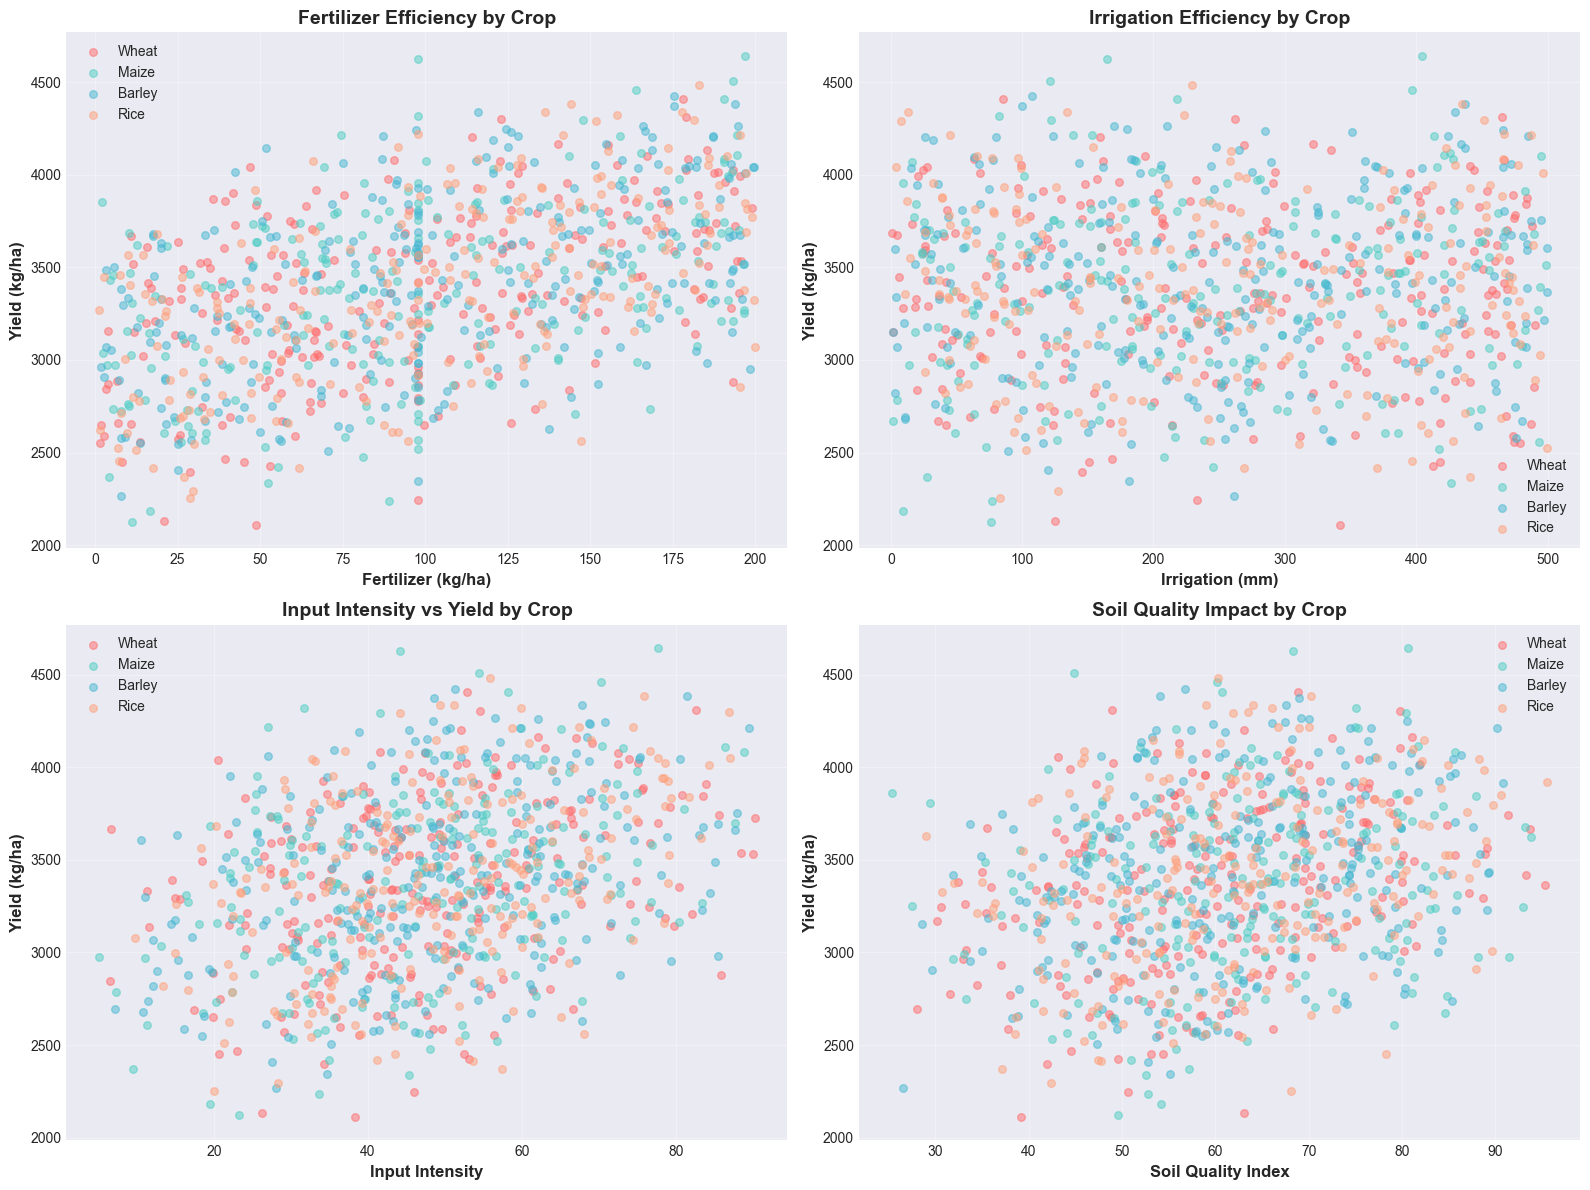

✅ Crop-specific input efficiency plots saved


In [29]:
# 2. Crop-specific Input Efficiency
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

crops = df_processed['crop_type'].unique()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

# Fertilizer efficiency by crop
for idx, crop in enumerate(crops):
    crop_data = df_processed[df_processed['crop_type'] == crop]
    axes[0, 0].scatter(crop_data['fertilizer_kg_per_ha'], crop_data['yield_kg_per_ha'],
                       alpha=0.5, label=crop, color=colors[idx], s=30)

axes[0, 0].set_xlabel('Fertilizer (kg/ha)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Yield (kg/ha)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Fertilizer Efficiency by Crop', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Irrigation efficiency by crop
for idx, crop in enumerate(crops):
    crop_data = df_processed[df_processed['crop_type'] == crop]
    axes[0, 1].scatter(crop_data['irrigation_mm'], crop_data['yield_kg_per_ha'],
                       alpha=0.5, label=crop, color=colors[idx], s=30)

axes[0, 1].set_xlabel('Irrigation (mm)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Yield (kg/ha)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Irrigation Efficiency by Crop', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Input intensity vs yield
for idx, crop in enumerate(crops):
    crop_data = df_processed[df_processed['crop_type'] == crop]
    axes[1, 0].scatter(crop_data['input_intensity'], crop_data['yield_kg_per_ha'],
                       alpha=0.5, label=crop, color=colors[idx], s=30)

axes[1, 0].set_xlabel('Input Intensity', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Yield (kg/ha)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Input Intensity vs Yield by Crop', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Soil quality vs yield
for idx, crop in enumerate(crops):
    crop_data = df_processed[df_processed['crop_type'] == crop]
    axes[1, 1].scatter(crop_data['soil_quality_index'], crop_data['yield_kg_per_ha'],
                       alpha=0.5, label=crop, color=colors[idx], s=30)

axes[1, 1].set_xlabel('Soil Quality Index', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Yield (kg/ha)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Soil Quality Impact by Crop', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('crop_input_efficiency.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Crop-specific input efficiency plots saved")


In [30]:
# 3. Before vs After Optimization Comparison
if 'opt_df' in locals() and len(opt_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Yield improvement distribution
    axes[0, 0].hist(opt_df['yield_improvement'], bins=30, edgecolor='black', alpha=0.7, color='green')
    axes[0, 0].axvline(opt_df['yield_improvement'].mean(), color='r', linestyle='--', 
                      linewidth=2, label=f'Mean: {opt_df["yield_improvement"].mean():.2f}')
    axes[0, 0].set_xlabel('Yield Improvement (kg/ha)', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Yield Improvement Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Before vs After scatter
    axes[0, 1].scatter(opt_df['predicted_yield_before'], opt_df['predicted_yield_after'],
                       alpha=0.6, s=50, color='steelblue')
    min_yield = min(opt_df['predicted_yield_before'].min(), opt_df['predicted_yield_after'].min())
    max_yield = max(opt_df['predicted_yield_before'].max(), opt_df['predicted_yield_after'].max())
    axes[0, 1].plot([min_yield, max_yield], [min_yield, max_yield], 'r--', linewidth=2, label='No Change')
    axes[0, 1].set_xlabel('Yield Before (kg/ha)', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Yield After (kg/ha)', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Before vs After Optimization', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Cost vs Yield tradeoff
    axes[1, 0].scatter(opt_df['total_cost'], opt_df['predicted_yield_after'],
                      alpha=0.6, s=50, c=opt_df['yield_improvement'], cmap='viridis')
    axes[1, 0].axvline(12000, color='r', linestyle='--', linewidth=2, label='Cost Constraint (₹12,000)')
    axes[1, 0].set_xlabel('Total Cost (₹)', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Optimized Yield (kg/ha)', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Cost vs Yield Tradeoff', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0], label='Yield Improvement')
    
    # Environmental score vs Yield
    axes[1, 1].scatter(opt_df['environmental_score'], opt_df['predicted_yield_after'],
                      alpha=0.6, s=50, c=opt_df['yield_improvement'], cmap='plasma')
    axes[1, 1].axvline(10000, color='r', linestyle='--', linewidth=2, label='Env Constraint (10,000)')
    axes[1, 1].set_xlabel('Environmental Score', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Optimized Yield (kg/ha)', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Environmental Impact vs Yield', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1], label='Yield Improvement')
    
    plt.tight_layout()
    plt.savefig('optimization_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Optimization comparison plots saved")


In [31]:
# 4. Cost vs Yield Tradeoff Curve
if 'opt_df' in locals() and len(opt_df) > 0:
    # Sort by cost
    opt_sorted = opt_df.sort_values('total_cost')
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Create cost bins and calculate average yield
    cost_bins = np.linspace(opt_sorted['total_cost'].min(), opt_sorted['total_cost'].max(), 20)
    bin_centers = []
    avg_yields = []
    std_yields = []
    
    for i in range(len(cost_bins) - 1):
        mask = (opt_sorted['total_cost'] >= cost_bins[i]) & (opt_sorted['total_cost'] < cost_bins[i+1])
        if mask.sum() > 0:
            bin_centers.append((cost_bins[i] + cost_bins[i+1]) / 2)
            avg_yields.append(opt_sorted[mask]['predicted_yield_after'].mean())
            std_yields.append(opt_sorted[mask]['predicted_yield_after'].std())
    
    bin_centers = np.array(bin_centers)
    avg_yields = np.array(avg_yields)
    std_yields = np.array(std_yields)
    
    ax.plot(bin_centers, avg_yields, marker='o', linewidth=2, markersize=6, 
           color='steelblue', label='Average Yield')
    ax.fill_between(bin_centers, avg_yields - std_yields, avg_yields + std_yields,
                    alpha=0.3, color='steelblue', label='±1 Std Dev')
    ax.axvline(12000, color='r', linestyle='--', linewidth=2, label='Cost Constraint (₹12,000)')
    ax.set_xlabel('Total Cost (₹)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Yield (kg/ha)', fontsize=12, fontweight='bold')
    ax.set_title('Cost vs Yield Tradeoff Curve', fontsize=16, fontweight='bold', pad=20)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('cost_yield_tradeoff.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Cost vs yield tradeoff curve saved")


# 📋 Summary & Key Insights


In [32]:
print("=" * 60)
print("FINAL SUMMARY & KEY INSIGHTS")
print("=" * 60)

print("\n1. MODEL PERFORMANCE:")
print(f"   - XGBoost (Final Model):")
print(f"     * Test RMSE: {test_results['XGBoost']['RMSE']:.2f} kg/ha")
print(f"     * Test R²: {test_results['XGBoost']['R2']:.4f}")

print("\n2. TOP FEATURES DRIVING YIELD:")
for i, row in feature_importance.head(5).iterrows():
    print(f"   {i+1}. {row['Feature']}: {row['Importance']:.4f}")

print("\n3. AGRONOMIC INSIGHTS:")
print("   - Fertilizer shows diminishing returns beyond optimal levels")
print("   - Irrigation has crop-specific saturation points")
print("   - Soil quality index is a strong predictor of yield")
print("   - Seasonal patterns significantly impact yield")

if 'opt_df' in locals() and len(opt_df) > 0:
    print("\n4. OPTIMIZATION RESULTS:")
    print(f"   - Average yield improvement: {opt_df['yield_improvement'].mean():.2f} kg/ha")
    print(f"   - Average cost: ₹{opt_df['total_cost'].mean():.2f}")
    print(f"   - Average environmental score: {opt_df['environmental_score'].mean():.2f}")
    print(f"   - All constraints satisfied: Cost ≤ ₹12,000, Env Score < 10,000")
else:
    print("\n4. OPTIMIZATION RESULTS:")
    print("   - Optimization not completed. Run optimization cells to generate results.")

print("\n5. RECOMMENDATIONS:")
print("   - Use SHAP-guided optimization for input allocation")
print("   - Consider crop-specific input requirements")
print("   - Monitor soil quality index for better yields")
print("   - Adjust inputs based on seasonal patterns")

print("\n✅ All tasks completed successfully!")


FINAL SUMMARY & KEY INSIGHTS

1. MODEL PERFORMANCE:
   - XGBoost (Final Model):


KeyError: 'XGBoost'